# KD 指標選股與回測

KD 值公式：
* RSV(未成熟隨機值)：(今日收盤價-最近9天的最低價)/(最近9天最高價-最近9天的最低價)
* 當日K值：前日K值 * (2/3) + 當日RSV值 * (1/3)
* 當日D值：前日D值 * (2/3) + 當日K值 * (1/3)

買賣條件：K值由下往上突破D值，黃金交叉時買進；K值由上往下跌破D值，死亡交叉時賣出

![KD指標圖](j2-KD-chart.png)

回測步驟：
* 讀取歷史資料
* 計算回測指標
* 回測演算法設計
* 紀錄回測資料
* 績效計算

In [1]:
import sqlite3, os
import talib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 讀取歷史資料 - 0050 近五年資料

conn = sqlite3.connect(os.path.join('data', 'data.db'))

sqlstr = "select sid,date,開盤價,最高價,最低價,收盤價,成交股數 \
          from price where sid='0050' and date>datetime('2015-01-01')"
df = pd.read_sql(sqlstr, conn, index_col='date', parse_dates='date')

In [3]:
print(len(df))
df.drop_duplicates(inplace=True)  # 刪除重覆資料
print(len(df))
df.head()

1280
1277


,sid,開盤價,最高價,最低價,收盤價,成交股數
date,,,,,,
2015-01-05,0050,66.40,66.75,66.00,66.55,6295612
2015-01-06,0050,65.75,65.75,64.75,64.90,19501826
2015-01-07,0050,64.70,65.25,64.70,65.00,6991542
2015-01-08,0050,65.50,66.60,65.50,66.50,13153525
2015-01-09,0050,66.90,66.95,66.05,66.15,5891981


In [4]:
# 修改 columns 名稱：中文轉換成英文

df.rename(columns={'開盤價':'open', '收盤價':'close', '最高價':'high',
                    '最低價':'low', '成交股數':'volume'}, inplace=True)
df.tail(10)

,sid,open,high,low,close,volume
date,,,,,,
2020-03-18,0050,74.95,75.25,72.80,72.80,46790503
2020-03-19,0050,71.00,71.00,67.25,68.55,68038340
2020-03-20,0050,71.00,74.00,70.90,74.00,40910533
2020-03-23,0050,71.00,72.10,69.55,70.80,22465117
2020-03-24,0050,73.85,75.30,73.70,74.25,26956843
2020-03-25,0050,76.80,77.45,76.10,76.85,32687820
2020-03-26,0050,77.40,77.45,76.00,77.20,19215688
2020-03-27,0050,78.30,78.70,76.45,76.60,21953901
2020-03-30,0050,74.70,76.15,74.05,75.85,13605883


In [5]:
# 分別取出每一條資料值

Open = df['open']
High = df['high']
Low = df['low']
Close = df['close']
Volume = df['volume']

In [14]:
# 計算回測指標

K, D = talib.STOCH(High,Low,Close,fastk_period=9, slowk_period=3, slowd_period=3, slowk_matype=2, slowd_matype=0)
K

date
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
2015-01-09          NaN
                ...    
2020-03-25    50.514462
2020-03-26    67.210826
2020-03-27    77.358915
2020-03-30    77.385281
2020-03-31    77.510917
Length: 1277, dtype: float64

In [7]:
df['K'] = K
df['D'] = D

In [8]:
df['sK'] = K.shift(1)
df['sD'] = D.shift(1)
#df

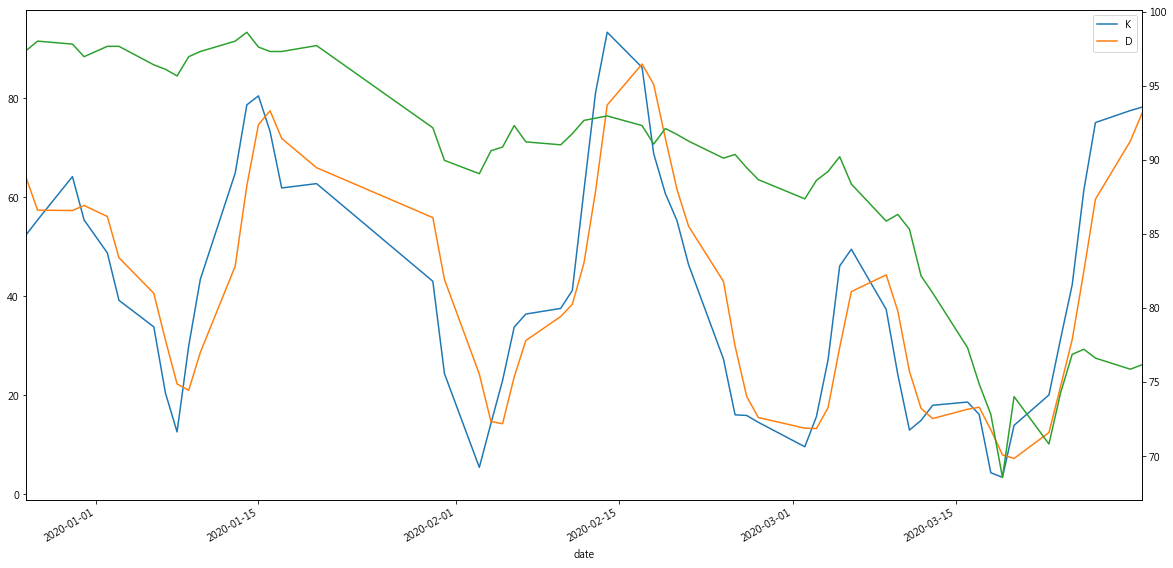

In [20]:
plt.rcParams['figure.figsize'] = (20, 10)
df['K'].tail(60).plot()     
df['D'].tail(60).plot()
plt.legend()
df['close'].tail(60).plot(secondary_y=True)

In [9]:
# 回測演算法
# 當（今天的 k > d ）且 （昨天的 k < d） 且 （今天的 k < 20） 時，買入
# 當（今天的 k < d ）且 （昨天的 k > d） 且 （今天的 k > 80） 時，買入

df['buy'] = (df['K'] > df['D']) & (df['sK'] < df['sD']) & (df['K'] < 20)
df['sell'] = (df['K'] < df['D']) & (df['sK'] > df['sD']) & (df['K'] > 80)
#df

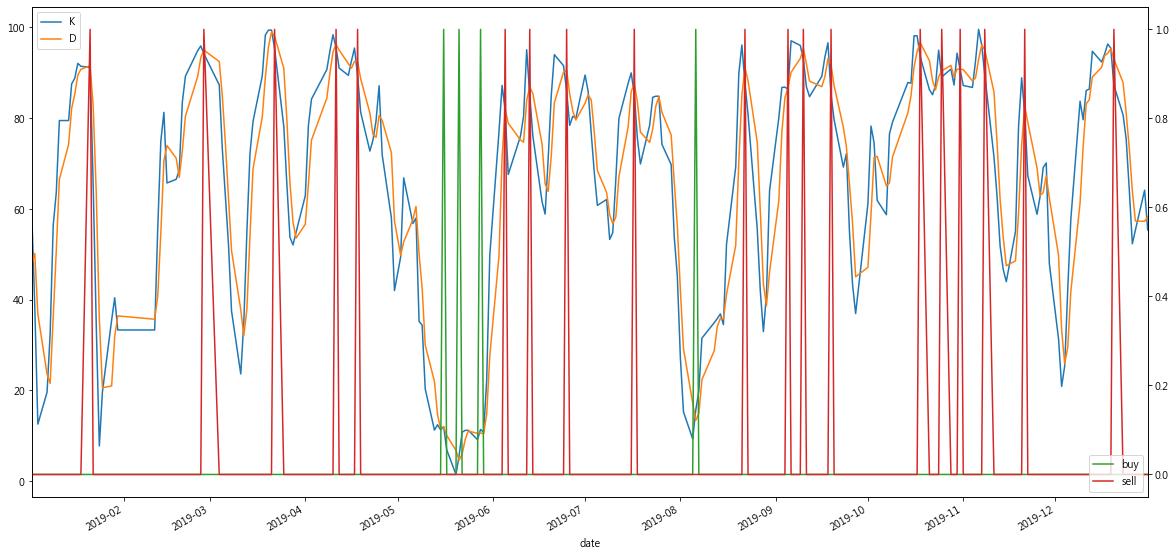

In [39]:
plt.rcParams['figure.figsize'] = (20, 10)
df['K']['2019'].plot()     
df['D']['2019'].plot()
plt.legend()
df['buy']['2019'].astype(int).plot(secondary_y=True)
df['sell']['2019'].astype(int).plot(secondary_y=True)
# df['K'].tail(60).plot()     
# df['D'].tail(60).plot()
# plt.legend()
# df['buy'].tail(60).astype(int).plot(secondary_y=True)
# df['sell'].tail(60).astype(int).plot(secondary_y=True)
plt.legend(loc='lower right')

In [10]:
# 紀錄回測資料

df.to_csv('0050-kd.csv')

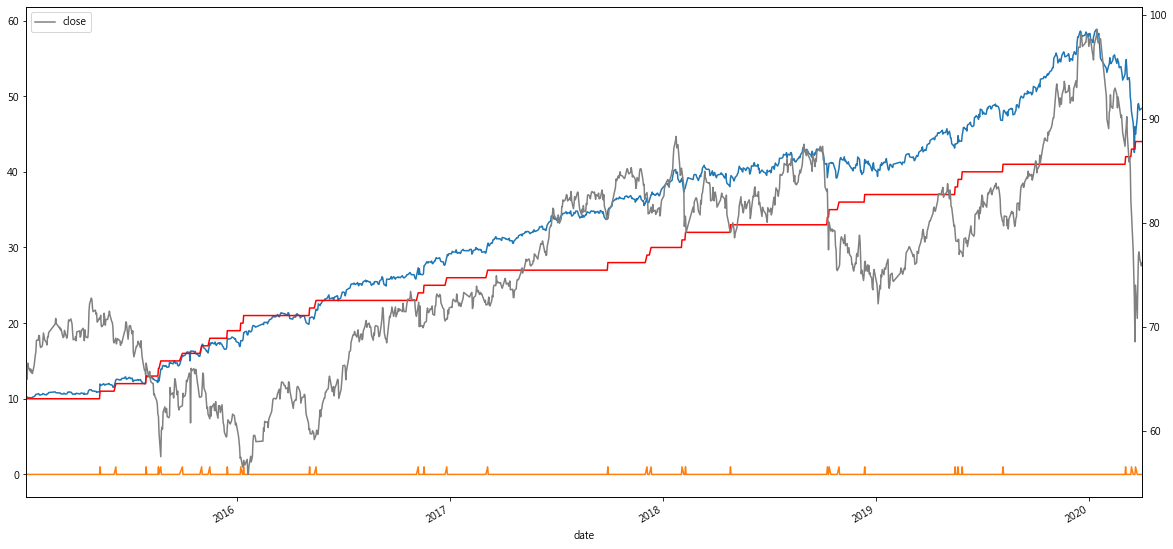

In [26]:
# 績效計算

# 設定起始資金為 10 萬，出現 buy 訊號，投入 1 萬元
total = [10]

# for i in range(len(df)):
#     if df['']

# zip() 函式將對應的元素打包成一個個 tuple
# zip([1,2,3],[4,5,6]) -> (1,4), (2,5), (3,6)
# zip(buy訊號, 後天股價漲幅)
# 出現 buy 訊號隔天買入股票, shift(-1) 明日收盤價, -2 後天
for v, p in zip(df['buy'][1:], df['close'].shift(-2)/df['close'].shift(-1)):
    #print(v, p)
    total.append(total[-1]*p + v)

# 繪製 0050 收盤價圖
plt.rcParams['figure.figsize'] = (20, 10)
df['close'].plot(secondary_y=True, color='gray')
plt.legend(loc='upper left')

# 繪製投資獲利
pd.Series(total, index=df['close'].index).plot(label='profit')
plt.legend(loc='lower right')

# 繪製買入的時間點
df['buy'].astype(int).plot()

# 繪製一樣的金額放在銀行的資產變化
(df['buy'].astype(int).cumsum() + 10).plot(color='red')

In [ ]:
# 股價 20, 持有 2 張，總價 40000
# 每日資產變化
# 20 40000
# 21 40000 * (21/20)
# 22 40000 * (21/20) * (22/21)
# 19 40000 * (21/20) * (22/21) * (19/22)
# 依此類推

In [54]:
buy1 = df[df['buy']]

# 解釋KDJ不同

https://zhuanlan.zhihu.com/p/40098124